<a href="https://colab.research.google.com/github/LuciusMelillo09/DataScience/blob/main/Unit4/Copy_of_Unit4Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install "preliz"

In [36]:
import preliz as pz
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import arviz as az
import pymc as pm
from matplotlib import pyplot as plt
import seaborn as sns
import graphviz as gv

In [3]:
data='https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/refs/heads/main/Data/basketball2324.csv'
bball_data = pd.read_csv(data,dtype={'Pos':'category'})

In [4]:
bball_data

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Player-additional
0,Precious Achiuwa,PF-C,24,TOT,74,18,1624,235,469,0.501,...,191,296,487,97,46,68,83,143,565,achiupr01
1,Bam Adebayo,C,26,MIA,71,71,2416,530,1017,0.521,...,159,578,737,278,81,66,162,159,1367,adebaba01
2,Ochai Agbaji,SG,23,TOT,78,28,1641,178,433,0.411,...,74,142,216,83,47,44,64,117,455,agbajoc01
3,Santi Aldama,PF,23,MEM,61,35,1618,247,568,0.435,...,72,280,352,138,43,54,69,89,654,aldamsa01
4,Nickeil Alexander-Walker,SG,25,MIN,82,20,1921,236,538,0.439,...,35,132,167,204,64,42,76,143,655,alexani01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
567,Thaddeus Young,PF,35,TOT,33,6,439,65,108,0.602,...,46,57,103,57,23,5,15,49,137,youngth01
568,Trae Young,PG,25,ATL,54,54,1942,433,1008,0.430,...,23,126,149,583,72,11,235,109,1389,youngtr01
569,Omer Yurtseven,C,25,UTA,48,12,545,99,184,0.538,...,72,136,208,29,8,18,37,52,222,yurtsom01
570,Cody Zeller,C,31,NOP,43,0,320,26,62,0.419,...,48,64,112,39,9,5,16,45,76,zelleco01


<Axes: ylabel='TRB'>

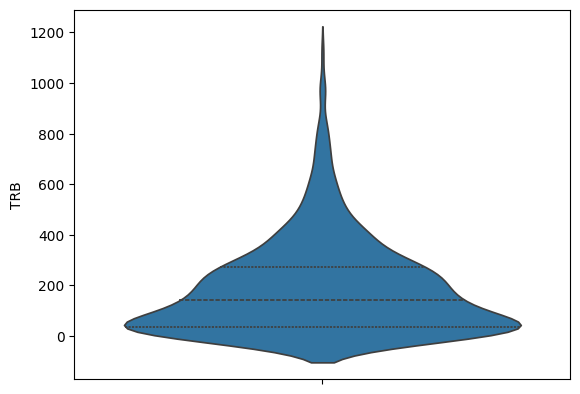

In [5]:
sns.violinplot(bball_data.TRB,inner='quart')


<Axes: ylabel='Pos'>

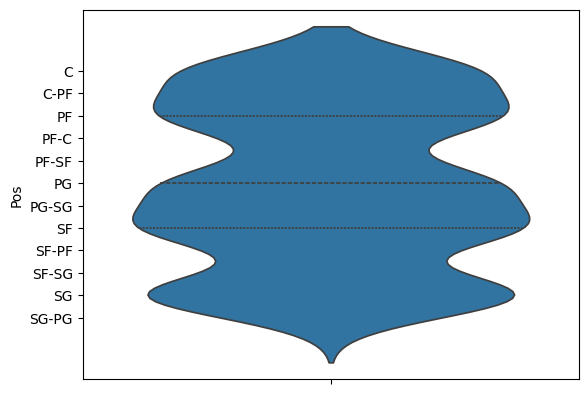

In [6]:
sns.violinplot(bball_data.Pos,inner='quart')


# Introduction
I'm using a dataset on NBA player data from the 23-24 season, and I'm using this to predict the Total Rebounds of NBA Players. I will use both a Normal Hierarchical and Normal Non-Hierarchical Model and compare them to see how they contrast.

# Causal Diagram

In [41]:
dag_cs = gv.Digraph(comment='cs_dag') #cs for chemical shift

dag_cs.node('H', 'Hierarchical Model')
dag_cs.node('N','Non-Hierarchical Model')
dag_cs.node('D','Difference between Hierarchical and Non-Hierarchical')
#dag_cs.node('A','Amino Acid Type')

dag_cs.edges(['HD','ND', ])

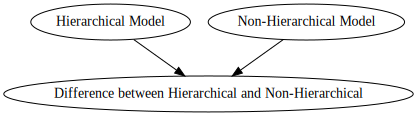

In [42]:
dag_cs

 ## Hierarchical

In [7]:
Pos_idx = bball_data.Pos.cat.codes.values

#an array of the four strings that represent position
Pos_codes = bball_data.Pos.cat.categories

#puts coords in a dict, so pymc can read them
bball_coords = {"Pos": Pos_codes}

In [8]:
bball_coords

{'Pos': Index(['C', 'C-PF', 'PF', 'PF-C', 'PF-SF', 'PG', 'PG-SG', 'SF', 'SF-PF',
        'SF-SG', 'SG', 'SG-PG'],
       dtype='object')}

In [48]:
with pm.Model(coords = bball_coords) as bball_model_h:
    # Hyperparameters
    # Overall mean for the distribution of position
    mu_hyper = pm.Normal('mu_hyper', mu=bball_data.TRB.mean(), sigma=bball_data.TRB.std())
    # Overall standard deviation for the distribution of position-specific means
    sigma_hyper = pm.HalfNormal('sigma_hyper', sigma=bball_data.TRB.std()/2)

    # Parameters for Positions
    # Mean TRB for each position, drawn hierarchically from the hyperparameters
    mu_pos = pm.Normal('mu_pos',
                        mu=mu_hyper,
                        sigma=sigma_hyper,
                        dims="Pos")

    # Parameters for Players
    # The mean TRB for each player, derived from their position's mean - GEMINI
    mu_player_TRB = pm.Deterministic('mu_player_for_likelihood', mu_pos[Pos_idx])

    # Observation standard deviation (shared across all players) - GEMINI
    sigma_obs = pm.HalfNormal('sigma_obs', sigma=bball_data.TRB.std()/2)

    # Likelihood: TRB is observed and follows a Normal distribution
    pm.Normal('TRB_observed',
              mu=mu_player_TRB,
              sigma=sigma_obs,
              observed=bball_data.TRB.values)

    idata_bball_h = pm.sample(target_accept = 0.95,progressbar=False)

In [50]:
with bball_model_normal_non_hierarchical:
    pm.sample_posterior_predictive(idata_bball_nh, model=bball_model_normal_non_hierarchical, extend_inferencedata=True,progressbar=False)

with bball_model_normal_hierarchical:
    pm.sample_posterior_predictive(idata_bball_h, model=bball_model_normal_hierarchical, extend_inferencedata=True,progressbar=False)

(0.0, 1200.0)

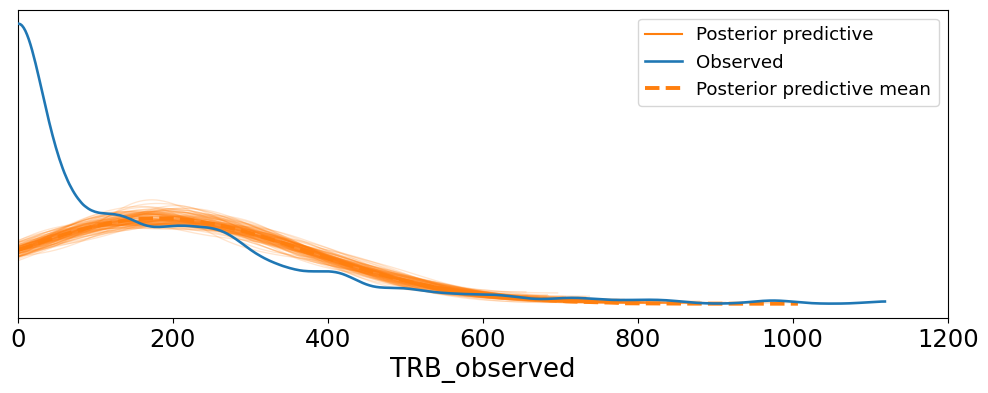

In [46]:
az.plot_ppc(idata_bball_h, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"])
plt.xlim([0,1200])

array([[<Axes: title={'center': 'mu_hyper'}>,
        <Axes: title={'center': 'mu_hyper'}>],
       [<Axes: title={'center': 'mu_player_for_likelihood'}>,
        <Axes: title={'center': 'mu_player_for_likelihood'}>],
       [<Axes: title={'center': 'mu_pos'}>,
        <Axes: title={'center': 'mu_pos'}>],
       [<Axes: title={'center': 'sigma_hyper'}>,
        <Axes: title={'center': 'sigma_hyper'}>],
       [<Axes: title={'center': 'sigma_obs'}>,
        <Axes: title={'center': 'sigma_obs'}>]], dtype=object)

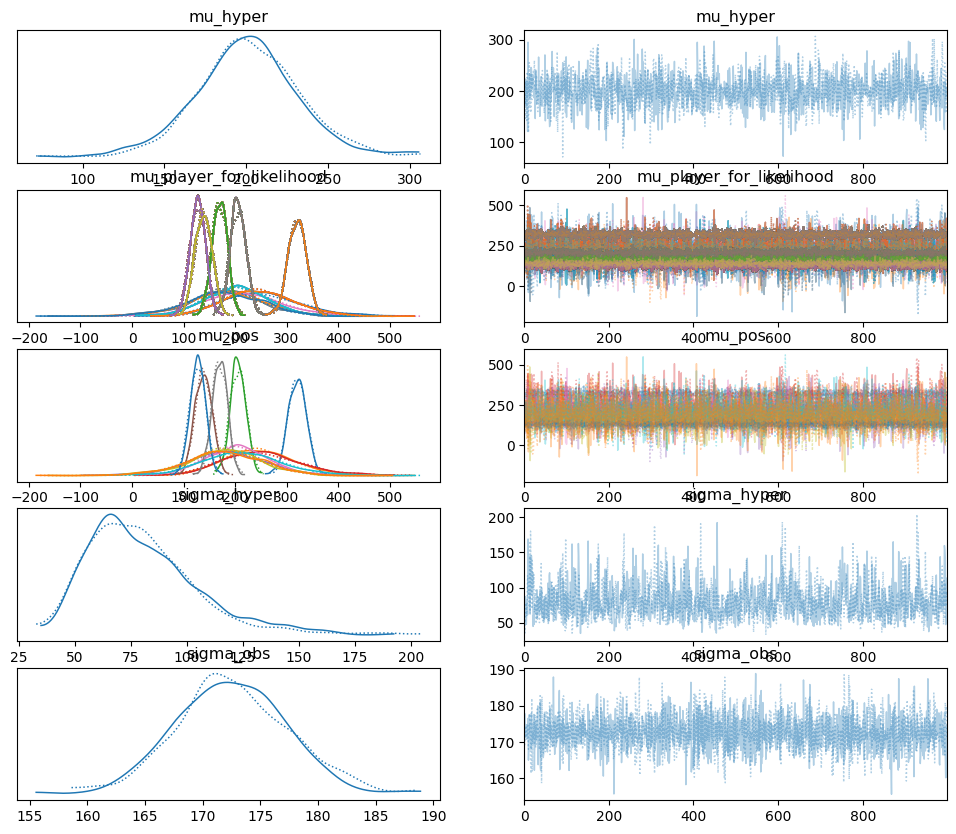

In [25]:
az.plot_trace(idata_bball_h)

Non-Hierarchical Normal Model


In [51]:
with pm.Model(coords = bball_coords) as bball_model_nh:
    # 1. Parameters for Positions (acting as independent priors, effectively their own 'hyperparameters')
    # Mean TRB for each position, with independent Normal priors
    mu_pos = pm.Normal('mu_pos',
                        mu=bball_data.TRB.mean(),
                        sigma=bball_data.TRB.std(),
                        dims="Pos")

    # 2. Parameters for Players
    # The mean TRB for each player, derived from their position's mean
    mu_player_TRB = pm.Deterministic('mu_player_for_likelihood', mu_pos[Pos_idx])

    # Observation standard deviation (shared across all players)
    sigma_obs = pm.HalfNormal('sigma_obs', sigma=bball_data.TRB.std()/2)

    # Likelihood: TRB is observed and follows a Normal distribution
    pm.Normal('TRB_observed',
              mu=mu_player_TRB,
              sigma=sigma_obs,
              observed=bball_data.TRB.values)

    idata_bball_nh = pm.sample(target_accept = 0.95,progressbar=False)

(0.0, 1200.0)

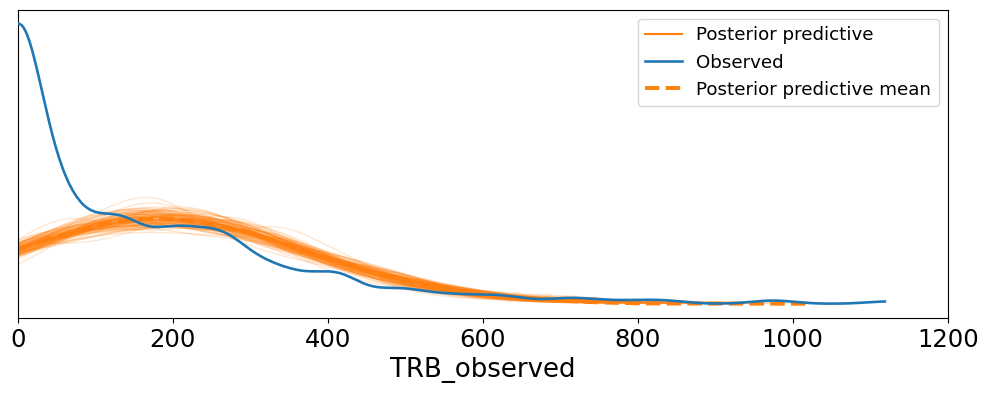

In [47]:
az.plot_ppc(idata_bball_nh, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"])
plt.xlim([0,1200])

array([[<Axes: title={'center': 'mu_player_for_likelihood'}>,
        <Axes: title={'center': 'mu_player_for_likelihood'}>],
       [<Axes: title={'center': 'mu_pos'}>,
        <Axes: title={'center': 'mu_pos'}>],
       [<Axes: title={'center': 'sigma_obs'}>,
        <Axes: title={'center': 'sigma_obs'}>]], dtype=object)

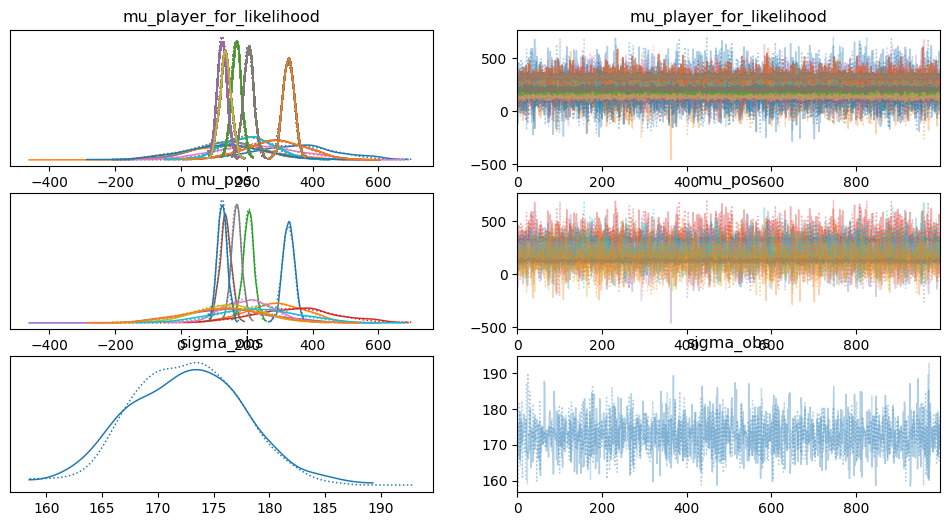

In [27]:
az.plot_trace(idata_bball_nh)

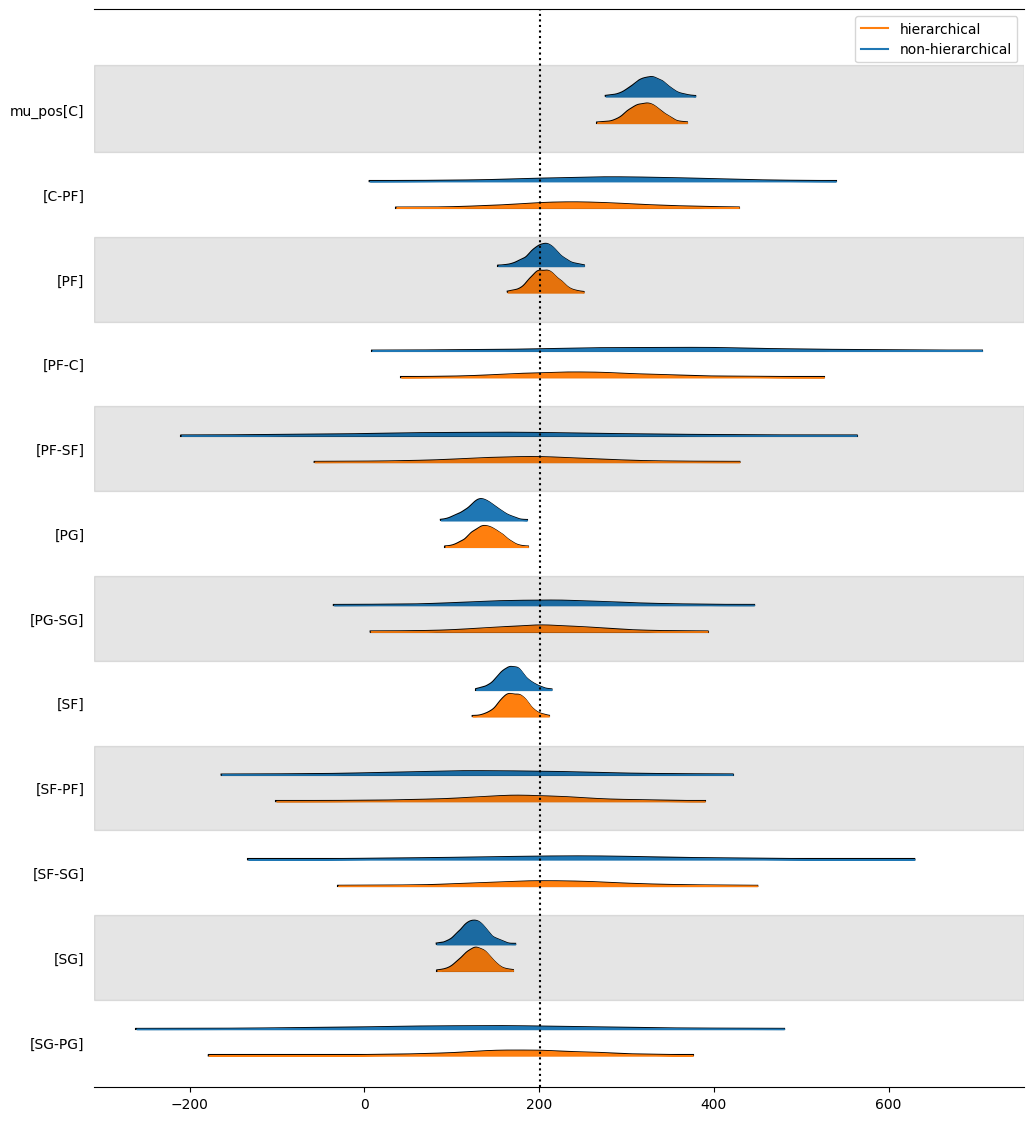

In [30]:
axes = az.plot_forest([idata_bball_nh, idata_bball_h], kind="ridgeplot", model_names=['non-hierarchical', 'hierarchical'], var_names='mu_pos', combined=True, figsize=(12, 14),hdi_prob=0.997)
y_lims = axes[0].get_ylim()
axes[0].vlines(idata_bball_h.posterior['mu_hyper'].mean(), *y_lims, color="k", ls=":");

# Conclusion
I noticed the hierarchical and non-hierarchical models look very similar, but for some of them the hierarchical model has a bit smaller of a range than the hierarchical model, and overall the non-hierarchical is skewed more towards the right.